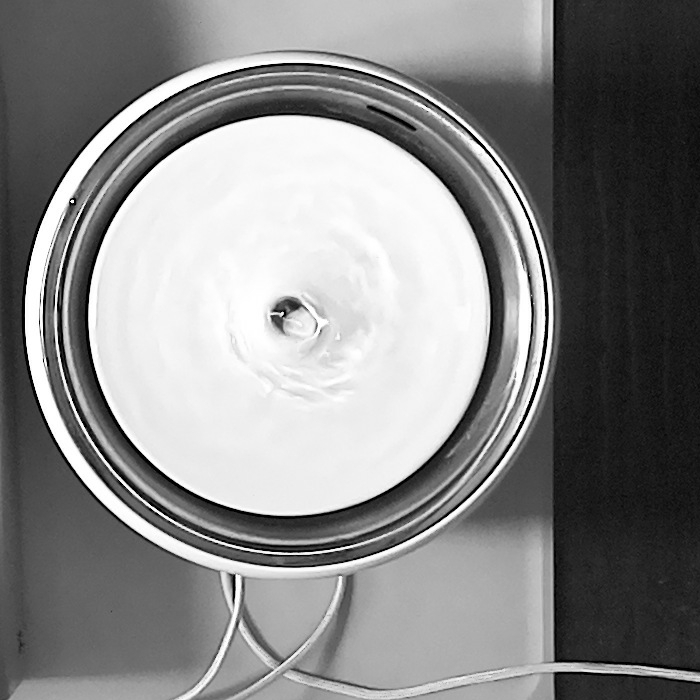

In [111]:
import random

from IPython.display import Image
PICTURES_DIR = "/Users/alsok/Downloads/response"
example_image = "/Users/alsok/Downloads/response/water_bowl_true/water_1673198297.567899_fuNn6dmfHPKzeCrGb7Lb82.jpeg"
Image(example_image)

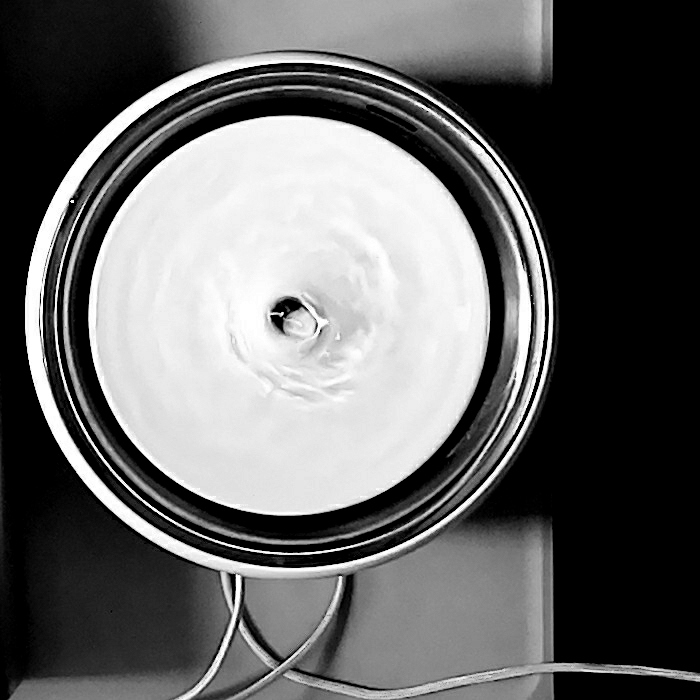

In [112]:
import tensorflow as tf
raw_jpeg = tf.io.read_file(example_image)
image = tf.image.decode_jpeg(raw_jpeg)
image = tf.image.adjust_brightness(image, -.3)
tf.keras.preprocessing.image.array_to_img(image)


In [113]:
data_dir = "/Users/alsok/Downloads/response"
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size=batch_size
)
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=batch_size
)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


In [114]:
import shutil
from tempfile import TemporaryDirectory
import random
from pathlib import Path
import shortuuid
from tensorflow import Tensor
from tensorflow.keras import Sequential
from tensorflow.keras import layers



def _manipulate_images(image: Tensor) -> list[Tensor]:
    inverted_image = tf.image.flip_left_right(image)
    rotated_1 = tf.image.rot90(image)
    rotated_2 = tf.image.rot90(rotated_1)
    rotated_3 = tf.image.rot90(rotated_2)
    inv_rotated_1 = tf.image.rot90(inverted_image)
    inv_rotated_2 = tf.image.rot90(inv_rotated_1)
    inv_rotated_3 = tf.image.rot90(inv_rotated_2)
    images_list = [
        image, rotated_1, rotated_2, rotated_3, inverted_image, inv_rotated_1, inv_rotated_2, inv_rotated_3
    ]
    modified_images = []
    for image in images_list:
        random_adjustment = random.randrange(30, 60)
        random_adjustment = (random_adjustment * -1) / 100
        modified_images.append(tf.image.adjust_brightness(image, random_adjustment))
    return images_list


def _save_images(directory: Path, filename_prefix: str, images: list[Tensor]) -> None:
    for image in images:
        filename = f"{filename_prefix}_{shortuuid.uuid()}.jpeg"
        output_file = directory.joinpath(filename)
        new_jpg = tf.image.encode_jpeg(image, format="grayscale", quality=100)
        tf.io.write_file(filename=str(output_file), contents=new_jpg)


def _create_training_pictures(raw_picture_path: Path, directory: Path):
    raw_jpeg = tf.io.read_file(str(raw_picture_path))
    water_image = tf.image.decode_jpeg(raw_jpeg)
    water_training_images = _manipulate_images(water_image)
    _save_images(directory, "water", water_training_images)

current_directory = Path(__file__).parent

with TemporaryDirectory() as tmp_dir:
    tmp_path = Path(tmp_dir)
    for directory in Path(PICTURES_DIR).glob("*"):
        if directory.is_dir():
            class_path = tmp_path.joinpath(directory.name)
            class_path.mkdir()
            for file in directory.glob("*.jpeg"):
                _create_training_pictures(file, class_path)
    shutil.copytree(tmp_path, current_directory.joinpath("modeling_dataset"))
    batch_size = 32
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      tmp_dir,
      validation_split=0.2,
      subset="training",
      seed=123,
      batch_size=batch_size
    )
    validation_ds = tf.keras.utils.image_dataset_from_directory(
      tmp_dir,
      validation_split=0.2,
      subset="validation",
      seed=123,
      batch_size=batch_size
    )
    class_names = train_ds.class_names
    print(class_names)
    
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    num_classes = len(class_names)

    model = Sequential([
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=2, strides=2),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=2, strides=2),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(pool_size=2, strides=2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    epochs=10
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )
    

NameError: name '__file__' is not defined

In [108]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 32, 32, 64)       

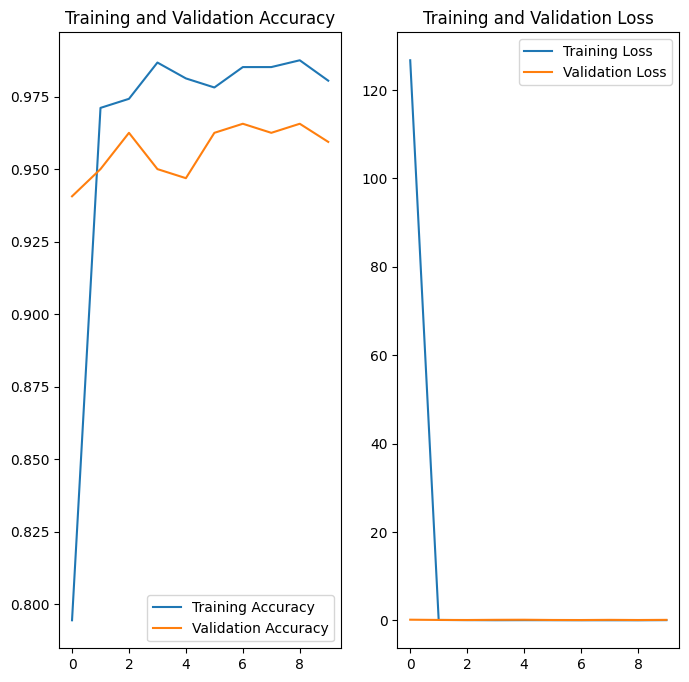

In [110]:

from matplotlib import pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()